In [29]:
# importing library
%matplotlib inline  
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sn
import matplotlib.pyplot as plt
from time import time
from sklearn.cross_validation import train_test_split # for spliting dataset
from sklearn.feature_extraction.text import CountVectorizer # bow-->1gram and 2 gram
from sklearn.feature_extraction.text import TfidfVectorizer # tf-idf|
from gensim.models import Word2Vec  # w2v
from gensim.models import KeyedVectors # to understanding w2v using google pre trained model
from sklearn.cross_validation import cross_val_score # k-fold cv

import warnings
warnings.filterwarnings("ignore")

# performance metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

>   # Loading the dataset

In [2]:
#loading the amazon dataset
dataset=pd.read_csv("Reviews.csv")

In [3]:
print(dataset.shape)
dataset.head()


(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


> # preprocessing the data

In [8]:
# sorting the value
dataset.sort_values(by='Id',inplace=True )
#finding the dublicate values using 'df.dublicated'
dataset[dataset.duplicated(subset={'ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Score','Time'})].shape
#alternate way to drop dublicate values
dataset_no_dup=dataset.drop_duplicates(subset={'ProfileName','Score','Time','Summary'},keep='first')
print(f"before {dataset.shape}")
print(f"after removing duplicate values-->shape = {dataset_no_dup.shape}")
# %age of no. of review reamin in data set
(dataset_no_dup.size/dataset.size)*100

# removing reviews where "HelpfulnessNumerator>HelpfulnessDenominator"
dataset_no_dup=dataset_no_dup[dataset_no_dup['HelpfulnessNumerator']<=dataset_no_dup['HelpfulnessDenominator']]


before (568454, 10)
after removing duplicate values-->shape = (393141, 10)


In [9]:
# taking reviews whose score is not equal to 3
filtered_dataset=dataset_no_dup[dataset_no_dup['Score']!=3]
filtered_dataset.shape
#creating a function to filter the reviews (if score>3 --> positive , if score<3 --> negative)
def partition(x):
    if x>3:
        return 'positive'
    else:
        return 'negative'

score=filtered_dataset['Score']
pos_neg=score.map(partition)
filtered_dataset['Score']=pos_neg
print(filtered_dataset.shape)
filtered_dataset.head()



(363393, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [10]:
#changing the format of timestamp to ('%Y-%m-%d %H:%M:%S'
import time
import datetime
time=[]
for timestamp in filtered_dataset['Time']:
    t=datetime.datetime.fromtimestamp(timestamp).strftime(('%Y-%m-%d %H:%M:%S'))
    time.append(t)
filtered_dataset['time']=time   

In [11]:
# sort by time
filtered_dataset.sort_values(by='time',inplace=True)

In [12]:
import re
import nltk
from nltk.corpus import stopwords

sno = nltk.stem.SnowballStemmer('english')#snowball stemmer

stop=set(stopwords.words('english')) #set of stopwords

#clean html tags
def cleanhtml(sent):
    pattern=re.compile(r'<.*?>')
    cleansent=re.sub(pattern," ",sent)
    return cleansent

#cleean punctuation
def cleanpunc(word):
    clean_punc=re.sub(r'[?|!|\'|"|#]',' ',word)
    clean_punc=re.sub(r'[.|,|)|(|\|/]',' ',clean_punc)
    return clean_punc

In [13]:
import string

x=0 # number of reviews you want to clean/pre-processed
positive_words=[]
negative_words=[]
str1=''
final_sent=[] # storing the list of final pre-processed sentences
i=0

for sent in filtered_dataset["Text"]:
    sent=cleanhtml(sent) #removing html tags
    filtered_sentence=[]
    for w in sent.split():
        for clean_words in cleanpunc(w).split():
            if((len(clean_words)>2) & (clean_words.isalpha())):
                if (clean_words.lower() not in stop):
                    s=(sno.stem(clean_words.lower()))
                    filtered_sentence.append(s)
                    if (filtered_dataset['Score'].values[i]=='positive'):
                        positive_words.append(s)
                    if (filtered_dataset['Score'].values[i]=='negative'):
                        negative_words.append(s)
                else:
                    continue
            else:
                continue
    str1=" ".join(filtered_sentence) #str of all the cleaned words
    final_sent.append(str1) # appending cleaned words to sentence
    i=i+1
          

In [14]:
print(len(final_sent))
print("\nBefore cleaning :\n",filtered_dataset["Text"][10])
print(f"\nAfter cleaning :\n {final_sent[10]}")



363393

Before cleaning :
 I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!

After cleaning :
 get crazi realli imposs today find french vhs version film could pleas tell someth tks


In [15]:
filtered_dataset['cleaned_text']=final_sent
print(filtered_dataset.shape)
filtered_dataset.head()

(363393, 12)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,time,cleaned_text
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,1999-10-08 03:00:00,witti littl book make son laugh loud recit car...
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,1999-10-25 03:00:00,rememb see show air televis year ago child sis...
451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,1999-12-02 03:00:00,beetlejuic well written movi everyth excel act...
230284,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",1999-12-06 03:00:00,twist rumplestiskin captur film star michael k...
451854,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,2000-01-03 03:00:00,beetlejuic excel funni movi keaton hilari wack...


## 1. Bag of word

In [18]:
# one gram-BOW from "sklean.feature_extraction.text.CountVectorizer"
count_vect=CountVectorizer()
bow_cleaned_text=count_vect.fit_transform(filtered_dataset['cleaned_text'])


In [19]:
# two gram_BOW 
count_vect_gram=CountVectorizer(ngram_range=(1,2))
bow_cleaned_text_2gram=count_vect_gram.fit_transform(filtered_dataset['cleaned_text'])
print("bow_cleaned_text",bow_cleaned_text.shape)
print("bow_cleaned_text_2gram",bow_cleaned_text_2gram.shape)

bow_cleaned_text (363393, 70047)
bow_cleaned_text_2gram (363393, 2881737)


## 2. TF-IDF

In [18]:
# tf-idf "from sklearn.feature_extraction.text.TfidfVectorizer"
tf_idf=TfidfVectorizer()
tf_idf_cleaned_text=tf_idf.fit_transform(filtered_dataset['cleaned_text'])
tf_idf_cleaned_text.shape

(363393, 70047)

In [21]:
"""# visualization tf-idf dataset
from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=False)
a=sc.fit_transform(tf_idf_cleaned_text[:100])
a.shape
a=a.todense()

from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 5000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(a)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, filtered_dataset['Text'][:100])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))
"""


'# visualization tf-idf dataset\nfrom sklearn.preprocessing import StandardScaler\nsc=StandardScaler(with_mean=False)\na=sc.fit_transform(tf_idf_cleaned_text[:100])\na.shape\na=a.todense()\n\nfrom sklearn.manifold import TSNE\nmodel = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 5000)\n# configuring the parameteres\n# the number of components = 2\n# default perplexity = 30\n# default learning rate = 200\n# default Maximum number of iterations for the optimization = 1000\n\ntsne_data = model.fit_transform(a)\n\n# creating a new data frame which help us in ploting the result data\ntsne_data = np.vstack((tsne_data.T, filtered_dataset[\'Text\'][:100])).T\ntsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))\n'

In [22]:
'''# Ploting the result of tsne
sn=sns.FacetGrid(tsne_df, hue="score", height=6)
sn=sn.map(plt.scatter,'dim2', 'dim1').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()
'''

'# Ploting the result of tsne\nsn=sns.FacetGrid(tsne_df, hue="score", height=6)\nsn=sn.map(plt.scatter,\'dim2\', \'dim1\').add_legend()\nplt.title("TSNE for Bag of Words")\nplt.show()\n'

In [23]:
# tf-idf 2-gram --> increasing no. of gram can increase the no. of dimension drastically
tf_idf_2gram = TfidfVectorizer(ngram_range=(1,2))
tf_idf_cleaned_text_2gram = tf_idf_2gram.fit_transform(filtered_dataset['cleaned_text'].values)
print("the type of count vectorizer ",type(tf_idf_cleaned_text_2gram))
print("the shape of out text TFIDF vectorizer ",tf_idf_cleaned_text_2gram.get_shape())
print("the number of unique words including both unigrams and bigrams ", tf_idf_cleaned_text_2gram.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (363393, 2881737)
the number of unique words including both unigrams and bigrams  2881737


## 3. avg word2vec

In [24]:
"""# understanding w2v using goolgle trained model of 300 dimension
# w2v lib from "gensim.models import KeyedVectors"
from gensim.models import KeyedVectors
google_w2v=KeyedVectors.load_word2vec_format("../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin.gz",encoding='utf8',binary=True)
"""

'# understanding w2v using goolgle trained model of 300 dimension\n# w2v lib from "gensim.models import KeyedVectors"\nfrom gensim.models import KeyedVectors\ngoogle_w2v=KeyedVectors.load_word2vec_format("../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin.gz",encoding=\'utf8\',binary=True)\n'

In [25]:
"""google_w2v.distance('woman','queen')"""

"google_w2v.distance('woman','queen')"

In [21]:
# converting our text-->vector using w2v with 50-dim
# more the dimension of each word = better the semantic of word
# using lib from "gensim.models.Word2Vec"
# to run w2v we need list of list of the words as w2v covert each world into number of dim

list_of_sent=[]
for sent in filtered_dataset['cleaned_text'].values:
    list_of_sent.append((str(sent)).split())
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50)
# vocablary of w2v model of amazon dataset
vocab=w2v_model.wv.vocab
len(vocab)

21817

In [27]:
"""# understanding w2v on amzon fine food reviews dataset
w2v_model.similar_by_word('women')"""

"# understanding w2v on amzon fine food reviews dataset\nw2v_model.similar_by_word('women')"

In [28]:
"""# w2v representaion of word "women" in 50-dim
w2v_model.wv['women']"""

'# w2v representaion of word "women" in 50-dim\nw2v_model.wv[\'women\']'

In [29]:
'''
-->procedure to make avg w2v of each reviews
    1. find the w2v of each word
    2. sum-up w2v of each word in a sentence
    3. divide the total w2v of sentence by total no. of words in the sentence
'''

# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list

for sent in list_of_sent[:20000]: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

print(len(sent_vectors))
print(len(sent_vectors[0]))

20000
50


In [30]:
sent_vectors[0] #avg w2v of first sentences

array([ 2.97285581e-01, -6.52227649e-01,  2.80164288e-01,  6.89652880e-01,
       -7.61053793e-01, -1.06156652e+00,  4.59796833e-01,  3.57239432e-01,
       -4.36815978e-01,  3.27063820e-01, -1.81614518e-01, -4.20933065e-01,
        2.99364594e-01, -1.02371697e+00,  3.50156881e-01,  3.85205827e-01,
        1.66331415e-02,  1.18157185e-01,  2.21462248e-01, -1.40745396e-01,
       -2.52946843e-01,  3.49748970e-01, -1.08262720e-01,  3.07247461e-01,
       -7.00229453e-01,  3.04494759e-01, -5.55374921e-01, -5.73498426e-01,
       -3.24831120e-01,  3.34849362e-04, -9.36198421e-01, -2.67455385e-01,
       -7.10921506e-02, -3.43747392e-01, -2.16919868e-01,  1.28889973e-01,
        1.34451114e-01, -1.81194368e-01,  2.88407407e-01, -1.11469096e-01,
       -3.09585115e-01,  2.74363020e-01,  6.14636841e-02, -1.92176646e-01,
       -3.22154351e-02,  7.15062112e-02, -3.57930148e-01, -3.84244789e-01,
        4.36845925e-02,  3.37055833e-01])

## 4. avg  TF-IDF W2V 

In [19]:
# tfidf words/col names
tfidf_feat = tf_idf.get_feature_names()

In [22]:
# TF-IDF weighted Word2Vec

# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent[:10000]: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = tf_idf_cleaned_text[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [33]:
len(tfidf_sent_vectors)

10000

# LOGISTIC REGRESSION

In [25]:
# function for logistic regression using grid search
def logistic_regression_GSCV(X,y,param,size=0.70):

    # spliting data based on timestamp
    size=0.70
    x_train=X[:round(X.shape[0]*size)]
    x_test=X[round(X.shape[0]*size):]
    y_train=y[:round(y.shape[0]*size)]
    y_test=y[round(X.shape[0]*size):]
    
    #for time series split
    tss=TimeSeriesSplit(10) 
    clf=LogisticRegression()

    # grid cross-validation to find optimal hyperparameter
    gridcv=GridSearchCV(estimator=clf,param_grid=param,cv=tss,n_jobs=-1)
    model_result=gridcv.fit(x_train,y_train)
    ypred=model_result.predict(x_test)
    print('best estimator : \n',gridcv.best_estimator_)

    #performance martics on genralisation
    # accuracy
    accuracy=accuracy_score(y_test,ypred)
    print(f"generalization accuracy is = {accuracy}")

    # confusion marix
    cm=confusion_matrix(y_test,ypred)
    plt.figure()
    plt.title('confusion matrix')
    sn.heatmap(cm, annot=True, fmt='g', annot_kws={'size':16})

    # classification report
    cr=classification_report(y_test,ypred)
    print('\n classification report :\n ',cr)
    
    return model_result

#*********************************************************************************************

# function for logistic regression using Random search CV
def logistic_regression_RSCV(X,y,param,size=0.70):

    # spliting data based on timestamp
    size=0.70
    x_train=X[:round(X.shape[0]*size)]
    x_test=X[round(X.shape[0]*size):]
    y_train=y[:round(y.shape[0]*size)]
    y_test=y[round(X.shape[0]*size):]
    
    #for time series split
    tss=TimeSeriesSplit(10) 
    clf=LogisticRegression()

    # grid cross-validation to find optimal hyperparameter
    randomcv=RandomizedSearchCV(estimator=clf,param_distributions=param,cv=tss,n_jobs=-1,random_state=1)
    model_result=randomcv.fit(x_train,y_train)
    ypred=model_result.predict(x_test)
    print('best estimator : \n',randomcv.best_estimator_)

    #performance martics on genralisation
    # accuracy
    accuracy=accuracy_score(y_test,ypred)
    print(f"generalization accuracy is = {accuracy}")

    # confusion marix
    cm=confusion_matrix(y_test,ypred)
    plt.figure()
    plt.title('confusion matrix')
    sn.heatmap(cm, annot=True, fmt='g', annot_kws={'size':16})

    # classification report
    cr=classification_report(y_test,ypred)
    print('\n classification report :\n ',cr)
    
    return model_result

#*********************************************************************************************


# function for ploting error vs C
def plot_errorvs_C(model_result):
    #model_result=model_result
    l1_error=[] # accuracy of 'l1' norm
    l2_error=[] # accuracy of 'l2' norm
    l1_c=[] # hyperparameter 'C' associate with 'l1' norm
    l2_c=[] # hyperparameter 'C' associate with 'l2' norm

    for i in model_result.grid_scores_:
        if i[0]['penalty']=='l2':
            l2_error.append(1-i[1])
            l2_c.append(i[0]['C'])
        else:
            l1_error.append(1-i[1])
            l1_c.append(i[0]['C'])

    #ploting error vs c
    plt.figure(figsize=(25,5))
    plt.title('error vs "C"')
    plt.xlim(-10,1001)
    plt.ylim(0,0.15)
    plt.xlabel("'C'")
    plt.ylabel('error')
    plt.plot(l1_c,l1_error,'b.-.', label='"l1"', linewidth=0.7)
    plt.plot(l2_c,l2_error,'r.-.', label='"l2"', linewidth=0.7)
    plt.legend()
    plt.grid()
    plt.show()

#*********************************************************************************************

#FUNCTION FOR SPARSITY
def sparsity(X,y,C,size=0.70):

    c=C
    non_zero=[]
    errors=[]
    
    # spliting data based on timestamp
    size=0.70
    x_train=X[:round(X.shape[0]*size)]
    x_test=X[round(X.shape[0]*size):]
    y_train=y[:round(y.shape[0]*size)]
    y_test=y[round(X.shape[0]*size):]
    
    #for time series split
    tss=TimeSeriesSplit(10) 
    clf=LogisticRegression(penalty='l1') # 'l1' norm for sparsity check
    
    for i in c:
        gridcv=GridSearchCV(estimator=clf,param_grid={'C':[i]},cv=tss,n_jobs=-1)
        model_result=gridcv.fit(x_train,y_train)
        errors.append((1-gridcv.score(x_test,y_test)))
        non_zero.append(np.count_nonzero(model_result.best_estimator_.coef_))
    sparsity=pd.DataFrame({'c':c,'non_zero_element':non_zero})
    error=pd.DataFrame({'c':c,'error':errors})
    
    # visualisation of hyperparamer 'C' vs non zero elements
    plt.figure(num=1,figsize=(19,7))
    sn.lineplot(data=sparsity,x='c',y='non_zero_element')
    plt.ylabel('non zero elements ')
    plt.xlabel('C = 1/lambda')
    plt.title('hyperparamer "C" vs non zero elements')
    plt.xlim(max(sparsity['c'])+1,min(sparsity['c'])-1)
    plt.grid(color='blue',linestyle='--', linewidth=0.4)
    plt.show()

    
    # visualisation of hyperparamer 'C' vs errors
    plt.figure(num=2,figsize=(19,7))
    plt.plot(error['c'],error['error'],color='r')
    plt.ylabel('errors ')
    plt.xlabel('C = 1/lambda')
    plt.title('hyperparamer "C" vs errors')
    plt.xlim(max(error['c'])+1,min(error['c'])-1)
    plt.grid(linestyle='-', linewidth=0.4)
    plt.show()

    
    print(sparsity)
    print('\n\n',error)
    return sparsity,error    

#*********************************************************************************************

# function for Feature Importance

# important --> use the same vectoriser which is used to train LR
# top positive weights and top negative weights in LR are top postive and neative features
def feature_importance(vectoriser,clf,n):
    

    vectoriser=vectoriser 
    weight=clf.coef_ # getting weights from logistic regreesion best hyerparameter
    feature_names=vectoriser.get_feature_names() # getting feature names from text vectorizer

    top_positive_weight=[]
    top_negative_weight=[]
    top_positive_words=[]
    top_negative_words=[]

    # finding top neative weights and top postive weights and corresponding features
    for (i,j),(k,l) in zip(sorted(zip(weight[0],feature_names))[:-n-1:-1],sorted(zip(weight[0],feature_names))[:n:]):
        top_positive_weight.append(i)
        top_positive_words.append(j)
        top_negative_weight.append(k)
        top_negative_words.append(l)

    # making Dataframe of posive and negavie features
    feat_imp={'top positive weights':top_positive_weight,'top positive words':top_positive_words,'top negative weight':top_negative_weight,'top negative words':top_negative_words}
    return pd.DataFrame(feat_imp)

#*********************************************************************************************

# function for perturbation text
def perturbation(X,y,size=0.70):
    
    # scalling dataset
    sc=StandardScaler(with_mean=False)
    x1=sc.fit_transform(X)

    '''norml=Normalizer()
    x1=norml.fit_transform(X)'''

    # spliting data based on timestamp
    size=0.70
    x_train=X[:round(X.shape[0]*size)]
    x_test=X[round(X.shape[0]*size):]
    y_train=y[:round(y.shape[0]*size)]
    y_test=y[round(X.shape[0]*size):]
    
    
    clf=LogisticRegression(penalty='l2',C=1)
    clf.fit(x_train,y_train)
    y_pred=clf.predict(x_test)
    print('accuracy before adding noise : ',accuracy_score(y_test,y_pred))

    #finding sparsity before adding noise
    from scipy.sparse import find # use to finf sparsity(non zero element in matrix)
    #weight before adding random error
    weight1=find(clf.coef_)[2]  # 'find'-->return : I,J, and V contain the row indices, column indices, and value of the nonzero matrix entries
    print('number of non zero elements before adding noise = ',weight1.size)
    i,j,v=find(clf.coef_) # 'find'-->return : I,J, and V contain the row indices, column indices, and value of the nonzero matrix entries

    # creting small random noise
    e=np.random.uniform(-0.001,0.001,size=(weight1.size,))
    x_train_new=x_train
    x_train_new[i,j]=x_train_new[i,j]+e

    clf1=LogisticRegression(penalty='l2',C=1)
    clf1.fit(x_train_new,y_train)
    y_pred=clf1.predict(x_test)
    print('\naccuracy after adding noise : ',accuracy_score(y_test,y_pred))

    weight2=find(clf1.coef_)[2]
    print('number of non zero elements after adding noise = ',weight2.size)
    diff=(abs(weight1-weight2)/weight1)*100
    print('\nnumber of features which is collinear = ',diff[diff>30].size)

### 1.  a ) Logistic Regression on BOW unigram

In [35]:
n=100000
X=bow_cleaned_text[:n]
y=filtered_dataset['Score'][:n]

"""sc=StandardScaler(with_mean=False)
x1=sc.fit_transform(X)"""

norml=Normalizer()
X=norml.fit_transform(X)


best estimator : 
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
generalization accuracy is = 0.9227666666666666

 classification report :
               precision    recall  f1-score   support

   negative       0.79      0.60      0.68      4123
   positive       0.94      0.97      0.96     25877

avg / total       0.92      0.92      0.92     30000



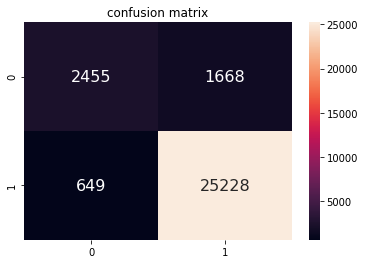

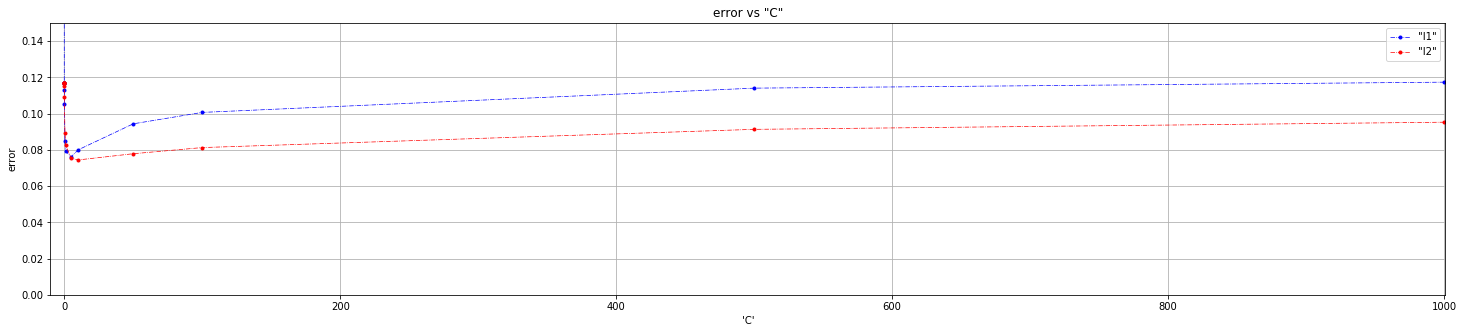

In [36]:

param={'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} # parameter for gridsearchCV
model_result_grid=logistic_regression_GSCV(X,y,param,size=0.70)
plot_errorvs_C(model_result_grid)


best estimator : 
 LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
generalization accuracy is = 0.9229

 classification report :
               precision    recall  f1-score   support

   negative       0.78      0.61      0.69      4123
   positive       0.94      0.97      0.96     25877

avg / total       0.92      0.92      0.92     30000



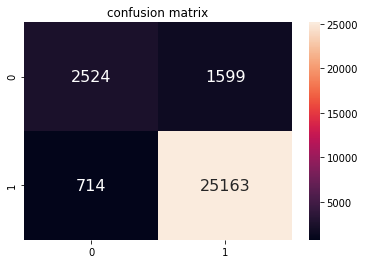

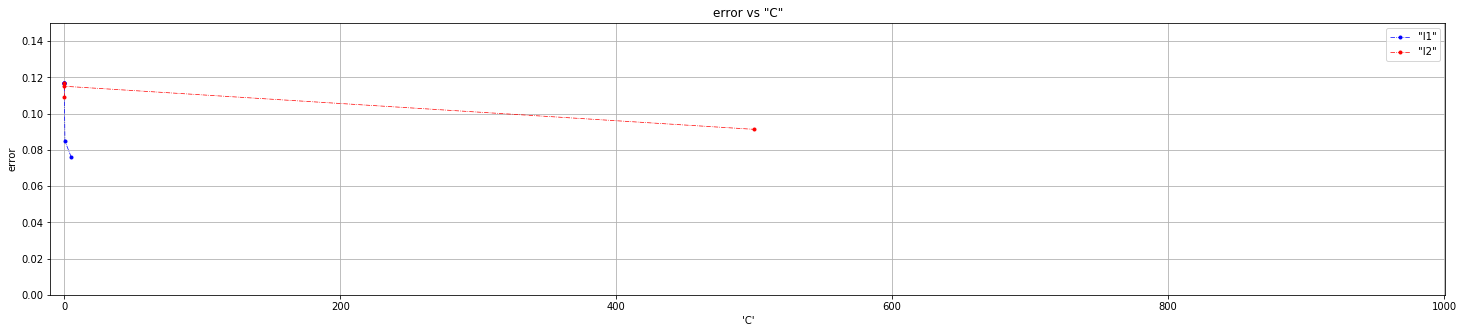

In [37]:
# using RandomSearch Cv
param={'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} # parameter for gridsearchCV
model_result_random=logistic_regression_RSCV(X,y,param,size=0.70)
plot_errorvs_C(model_result_random)

#### Sparsity in BOW unigram: change in sparsity with reducing hyperparameter 'C' using 'l1' norm

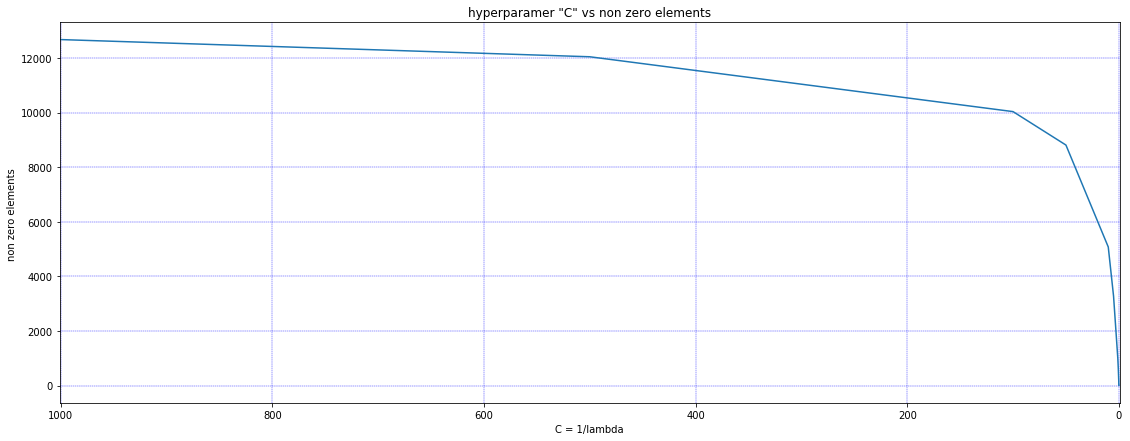

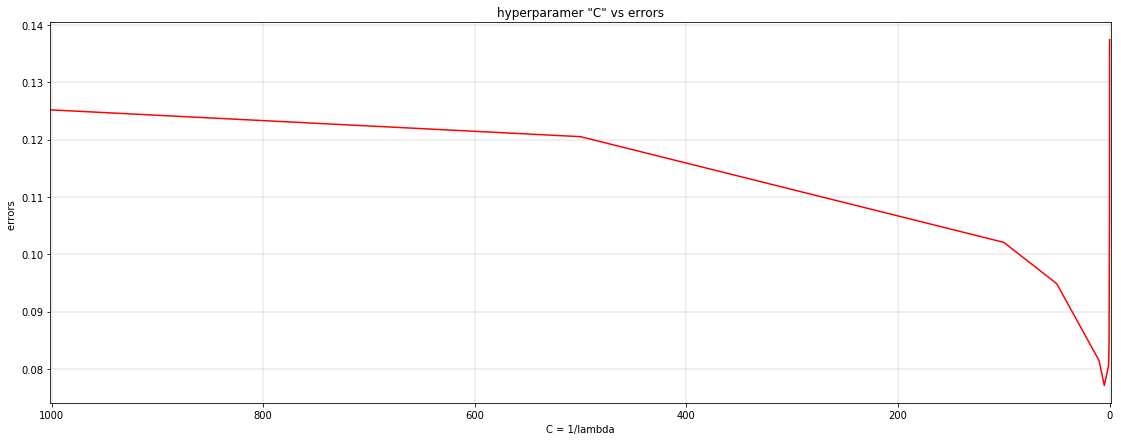

            c  non_zero_element
0   1000.0000             12673
1    500.0000             12043
2    100.0000             10034
3     50.0000              8809
4     10.0000              5075
5      5.0000              3275
6      1.0000              1012
7      0.5000               615
8      0.1000               183
9      0.0500                83
10     0.0100                10
11     0.0050                 2
12     0.0010                 0
13     0.0005                 0
14     0.0001                 0


             c     error
0   1000.0000  0.125167
1    500.0000  0.120500
2    100.0000  0.102067
3     50.0000  0.094867
4     10.0000  0.081467
5      5.0000  0.077100
6      1.0000  0.080533
7      0.5000  0.084433
8      0.1000  0.107233
9      0.0500  0.120467
10     0.0100  0.137433
11     0.0050  0.137433
12     0.0010  0.137433
13     0.0005  0.137433
14     0.0001  0.137433


In [38]:
n=100000
X=bow_cleaned_text[:n]
y=filtered_dataset['Score'][:n]

"""sc=StandardScaler(with_mean=False)
x1=sc.fit_transform(X)"""

norml=Normalizer()
X=norml.fit_transform(X)

# checking the sparsity and errors with change in 'C'=1/lamda using "l1" norm hyperparamer
C=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
result=sparsity(X,y,C,size=0.70)

#### perturbation test on BOW unigram

In [39]:
n=1000000
X=bow_cleaned_text[:n]
y=filtered_dataset['Score'][:n]

perturbation(X,y,size=0.70)

accuracy before adding noise :  0.9138949531270065
number of non zero elements before adding noise =  58042

accuracy after adding noise :  0.9139224715184648
number of non zero elements after adding noise =  58042

number of features which is collinear =  130


#### Feature Importance : LR on BOW unigram

In [40]:
clf=model_result_grid.best_estimator_ # model_result from gridsearch_CV

# important --> use the same vectoriser which is used to train LR
feature_importance(count_vect,clf,15)

,top positive weights,top positive words,top negative weight,top negative words
0,9.940899,perfect,-16.591163,worst
1,9.042868,amaz,-10.494996,terribl
2,8.739163,delici,-9.990445,aw
3,8.724351,excel,-9.256879,bland
4,8.507297,addict,-9.199172,threw
5,8.046713,uniqu,-9.027875,horribl
6,8.016401,best,-8.954152,tasteless
7,7.961803,skeptic,-8.923561,disappoint
8,7.751554,awesom,-8.709309,wors
9,7.591524,fantast,-8.610611,unpleas


### 1.  b ) Logistic Regression on BOW bigram

In [53]:
n=500000
X=bow_cleaned_text_2gram[:n]
y=filtered_dataset['Score'][:n]

norml=Normalizer()
X=norml.fit_transform(X)



best estimator : 
 LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
generalization accuracy is = 0.9293602891265662

 classification report :
               precision    recall  f1-score   support

   negative       0.85      0.72      0.78     19043
   positive       0.94      0.97      0.96     89975

avg / total       0.93      0.93      0.93    109018



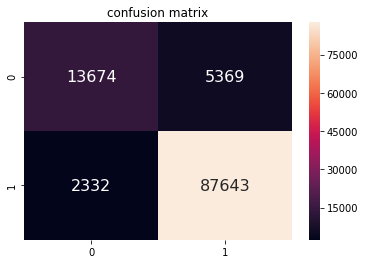

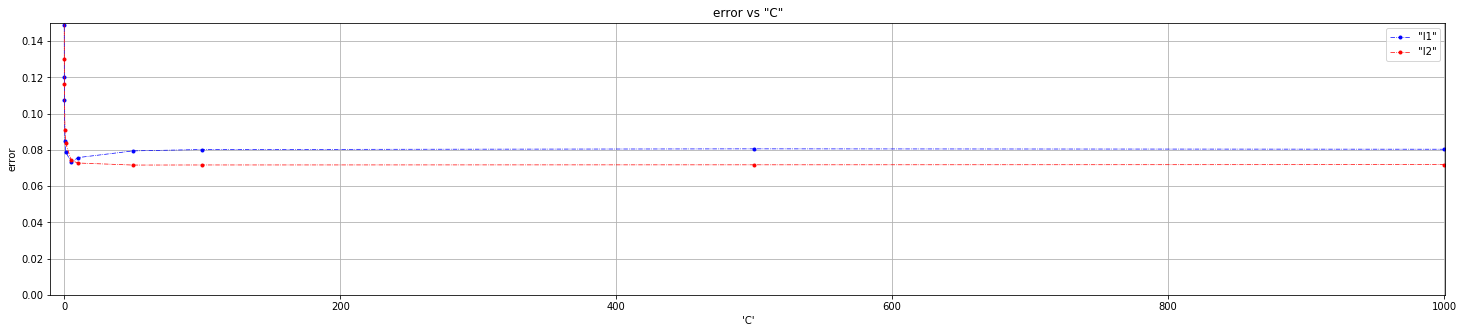

In [54]:
# using GridSearchCV
param={'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} # parameter for gridsearchCV
model_result_grid=logistic_regression_GSCV(X,y,param,size=0.70)
plot_errorvs_C(model_result_grid)


best estimator : 
 LogisticRegression(C=500, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
generalization accuracy is = 0.928672329340109

 classification report :
               precision    recall  f1-score   support

   negative       0.85      0.72      0.78     19043
   positive       0.94      0.97      0.96     89975

avg / total       0.93      0.93      0.93    109018



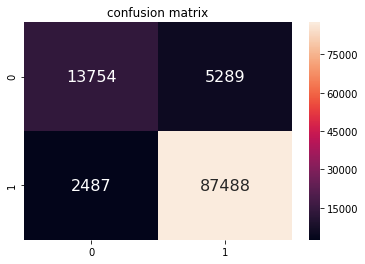

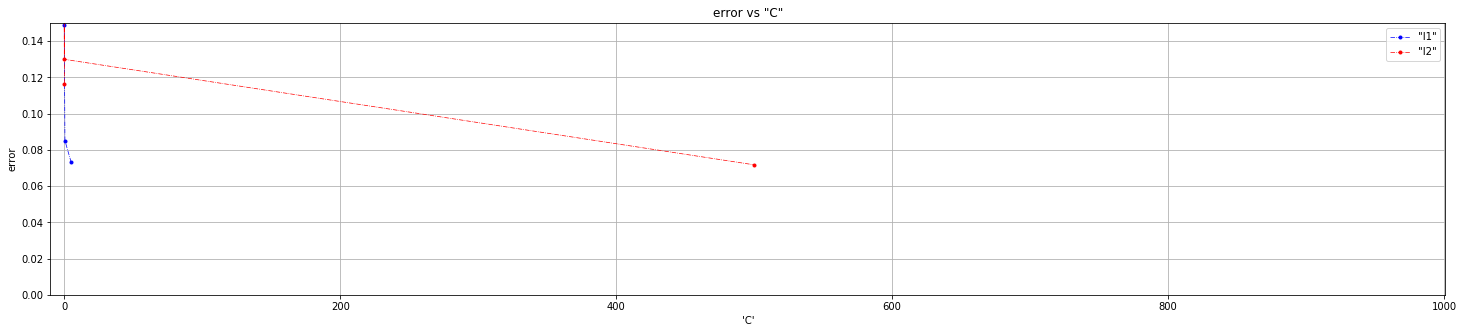

In [55]:
# using RandomSearch Cv
param={'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} # parameter for gridsearchCV
model_result_random=logistic_regression_RSCV(X,y,param,size=0.70)
plot_errorvs_C(model_result_random)

#### Sparsity in BOW bigram: change in sparsity with reducing hyperparameter 'C' using 'l1' norm

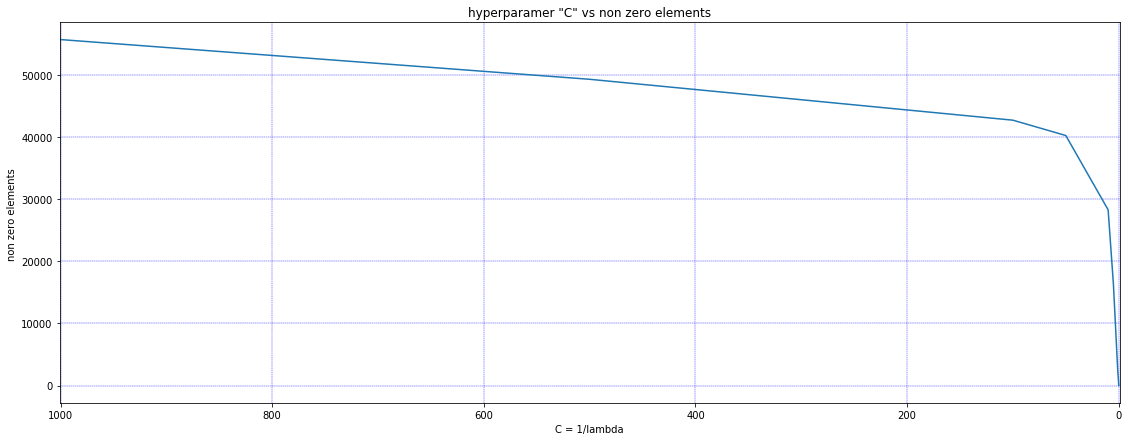

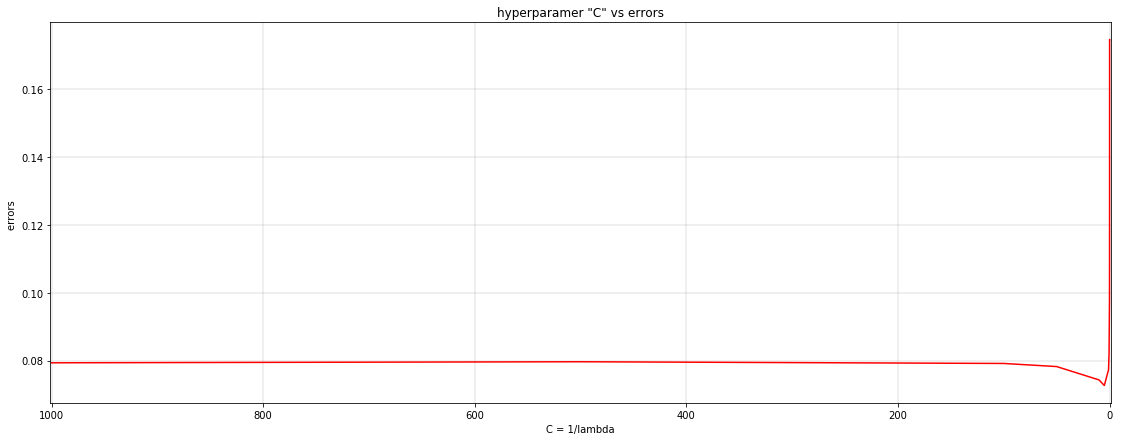

            c  non_zero_element
0   1000.0000             55631
1    500.0000             49244
2    100.0000             42668
3     50.0000             40201
4     10.0000             28252
5      5.0000             16257
6      1.0000              2651
7      0.5000              1450
8      0.1000               443
9      0.0500               254
10     0.0100                57
11     0.0050                19
12     0.0010                 1
13     0.0005                 0
14     0.0001                 0


             c     error
0   1000.0000  0.079336
1    500.0000  0.079647
2    100.0000  0.079143
3     50.0000  0.078226
4     10.0000  0.074290
5      5.0000  0.072639
6      1.0000  0.077290
7      0.5000  0.082271
8      0.1000  0.097745
9      0.0500  0.109505
10     0.0100  0.155277
11     0.0050  0.171311
12     0.0010  0.174678
13     0.0005  0.174678
14     0.0001  0.174678


In [56]:
# checking the sparsity using "l1" norm hyperparamer and change in 'C'=1/lamda 
C=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
result=sparsity(X,y,C,size=0.70)

#### perturbation test on BOW bigram

In [57]:
n=500000
X=bow_cleaned_text_2gram[:n]
y=filtered_dataset['Score'][:n]

norml=Normalizer()
X=norml.fit_transform(X)


perturbation(X,y,size=0.70)

accuracy before adding noise :  0.9202150103652608
number of non zero elements before adding noise =  2273361

accuracy after adding noise :  0.920205837568108
number of non zero elements after adding noise =  2273361

number of features which is collinear =  7160


#### Feature Importance : LR on BOW unigram

In [63]:
clf=model_result_grid.best_estimator_ # model_result from gridsearch_CV

# important --> use the same vectoriser which is used to train LR
feature_importance(count_vect_gram,clf,15)

,top positive weights,top positive words,top negative weight,top negative words
0,14.214588,addit snappl,-13.756701,also favor
1,13.095262,actual earl,-10.131999,actual scrub
2,12.334279,accept catnip,-9.517387,absorb ldl
3,11.825980,agre wolf,-9.297609,almost settl
4,10.530587,add attempt,-8.787389,admit saltahol
5,10.466435,affluenc friend,-8.600487,alo took
6,9.535037,abl subcrib,-8.285740,along though
7,8.852450,allergi hook,-8.013649,actual sparkl
8,8.768210,admit ovaltin,-7.955991,alcohol ala
9,8.692640,absorb measur,-7.788153,also messi


### 2.  a ) Logistic Regression on TF-IDF unigram

In [58]:
n=500000
X=tf_idf_cleaned_text[:n]
y=filtered_dataset['Score'][:n]

norml=Normalizer()
X=norml.fit_transform(X)



best estimator : 
 LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
generalization accuracy is = 0.9177475279311673

 classification report :
               precision    recall  f1-score   support

   negative       0.83      0.67      0.74     19043
   positive       0.93      0.97      0.95     89975

avg / total       0.91      0.92      0.91    109018



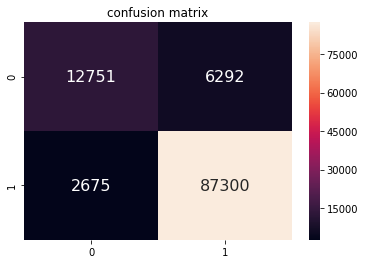

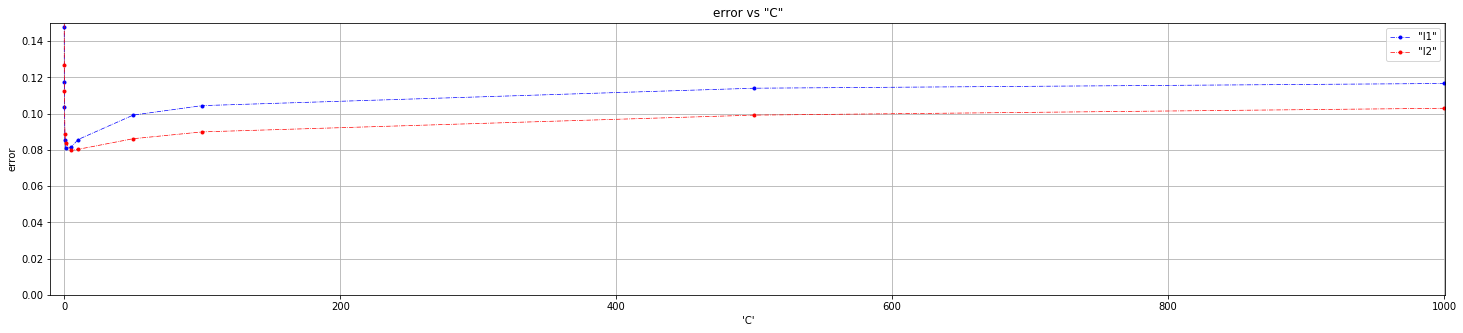

In [59]:
# using GridSearchCV
param={'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} # parameter for gridsearchCV
model_result_grid=logistic_regression_GSCV(X,y,param,size=0.70)
plot_errorvs_C(model_result_grid)


best estimator : 
 LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
generalization accuracy is = 0.9157295125575593

 classification report :
               precision    recall  f1-score   support

   negative       0.81      0.68      0.74     19043
   positive       0.93      0.97      0.95     89975

avg / total       0.91      0.92      0.91    109018



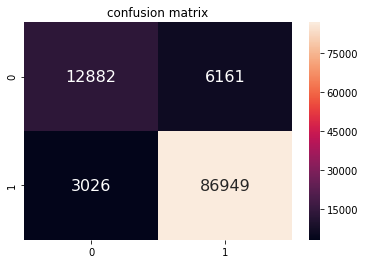

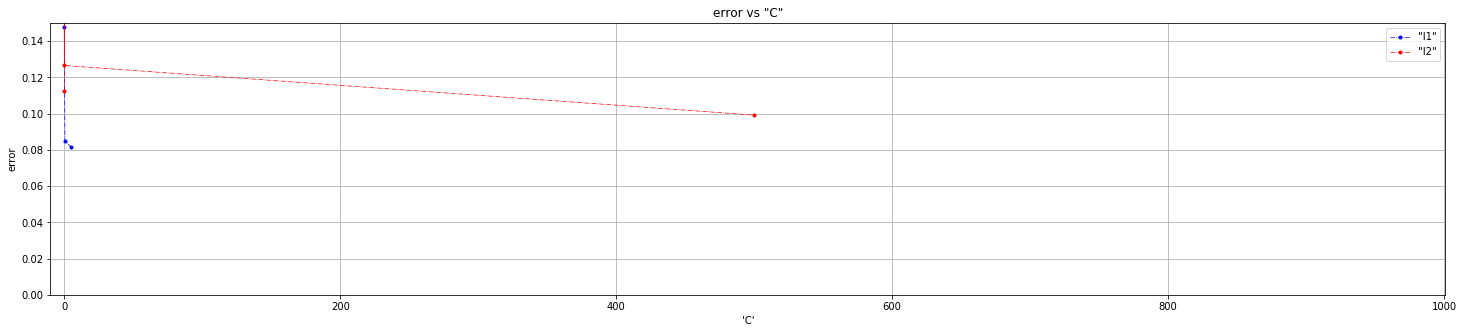

In [60]:
# using RandomSearch Cv
param={'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} # parameter for gridsearchCV
model_result_random=logistic_regression_RSCV(X,y,param,size=0.70)
plot_errorvs_C(model_result_random)

#### Sparsity in TF-IDF unigram: change in sparsity with reducing hyperparameter 'C' using 'l1' norm

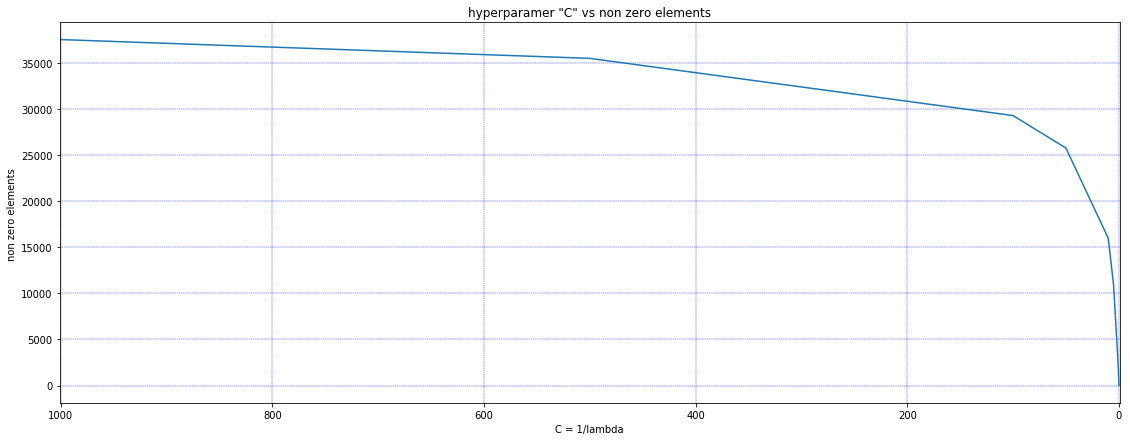

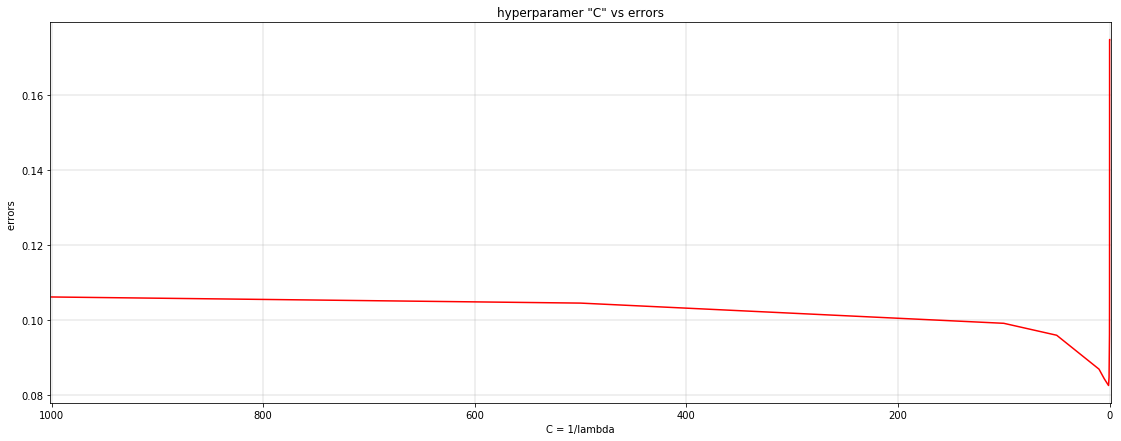

            c  non_zero_element
0   1000.0000             37579
1    500.0000             35538
2    100.0000             29325
3     50.0000             25792
4     10.0000             15997
5      5.0000             10923
6      1.0000              3049
7      0.5000              1870
8      0.1000               569
9      0.0500               325
10     0.0100                62
11     0.0050                23
12     0.0010                 0
13     0.0005                 0
14     0.0001                 0


             c     error
0   1000.0000  0.106083
1    500.0000  0.104451
2    100.0000  0.099066
3     50.0000  0.095883
4     10.0000  0.086848
5      5.0000  0.084270
6      1.0000  0.082491
7      0.5000  0.084692
8      0.1000  0.096113
9      0.0500  0.105882
10     0.0100  0.151159
11     0.0050  0.171091
12     0.0010  0.174678
13     0.0005  0.174678
14     0.0001  0.174678


In [61]:
# checking the sparsity using "l1" norm hyperparamer and change in 'C'=1/lamda 
C=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
result=sparsity(X,y,C,size=0.70)

#### perturbation test on TF-IDF unigram

In [62]:
n=500000
X=tf_idf_cleaned_text[:n]
y=filtered_dataset['Score'][:n]

norml=Normalizer()
X=norml.fit_transform(X)


perturbation(X,y,size=0.70)

accuracy before adding noise :  0.916830248215891
number of non zero elements before adding noise =  58042

accuracy after adding noise :  0.916830248215891
number of non zero elements after adding noise =  58042

number of features which is collinear =  68


  #### Feature Importance : LR onTF-IDF unigram

In [66]:
clf=model_result_grid.best_estimator_ # model_result from gridsearch_CV

# important --> use the same vectoriser which is used to train LR
feature_importance(tf_idf,clf,15)

,top positive weights,top positive words,top negative weight,top negative words
0,14.214588,great,-13.756701,worst
1,13.095262,delici,-10.131999,disappoint
2,12.334279,best,-9.517387,aw
3,11.825980,perfect,-9.297609,terribl
4,10.530587,excel,-8.787389,horribl
5,10.466435,love,-8.600487,threw
6,9.535037,amaz,-8.285740,undrink
7,8.852450,skeptic,-8.013649,disgust
8,8.768210,hook,-7.955991,return
9,8.692640,awesom,-7.788153,yuck


### 2.  b) Logistic Regression on TF-IDF bigram

In [67]:
n=50000
X=tf_idf_cleaned_text_2gram[:n]
y=filtered_dataset['Score'][:n]

norml=Normalizer()
X=norml.fit_transform(X)


best estimator : 
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
generalization accuracy is = 0.9248

 classification report :
               precision    recall  f1-score   support

   negative       0.77      0.52      0.62      1792
   positive       0.94      0.98      0.96     13208

avg / total       0.92      0.92      0.92     15000



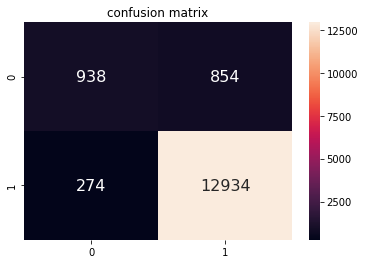

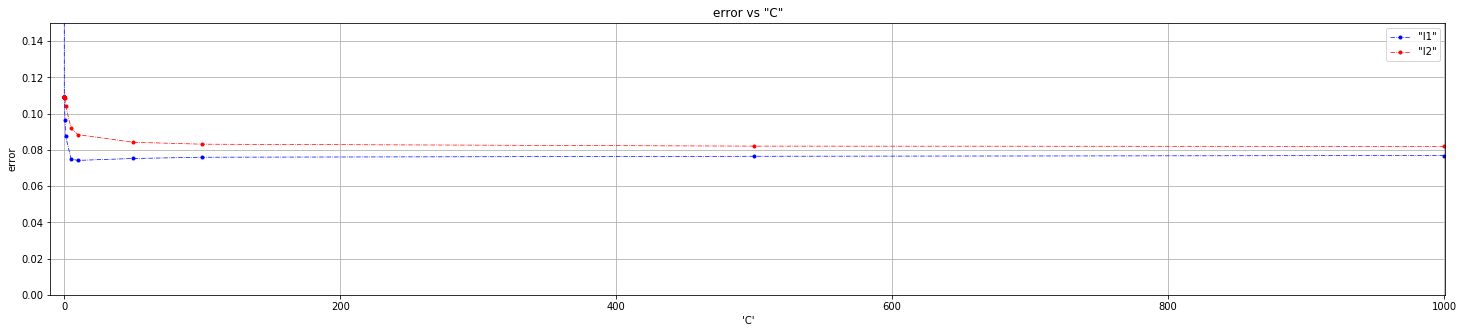

In [68]:
# using GridSearchCV
param={'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} # parameter for gridsearchCV
model_result_grid=logistic_regression_GSCV(X,y,param,size=0.70)
plot_errorvs_C(model_result_grid)


best estimator : 
 LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
generalization accuracy is = 0.9251333333333334

 classification report :
               precision    recall  f1-score   support

   negative       0.79      0.51      0.62      1792
   positive       0.94      0.98      0.96     13208

avg / total       0.92      0.93      0.92     15000



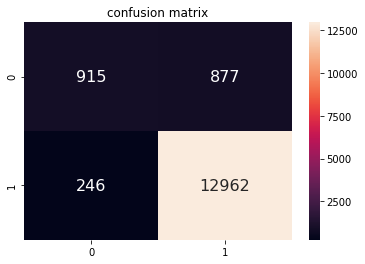

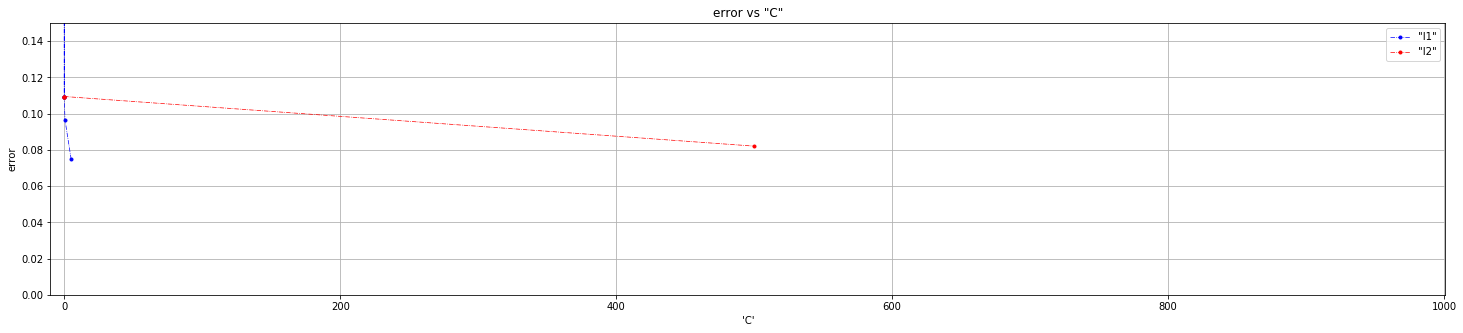

In [69]:
# using RandomSearch Cv
param={'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} # parameter for gridsearchCV
model_result_random=logistic_regression_RSCV(X,y,param,size=0.70)
plot_errorvs_C(model_result_random)

#### Sparsity in TF-IDF bigram: change in sparsity with reducing hyperparameter 'C' using 'l1' norm

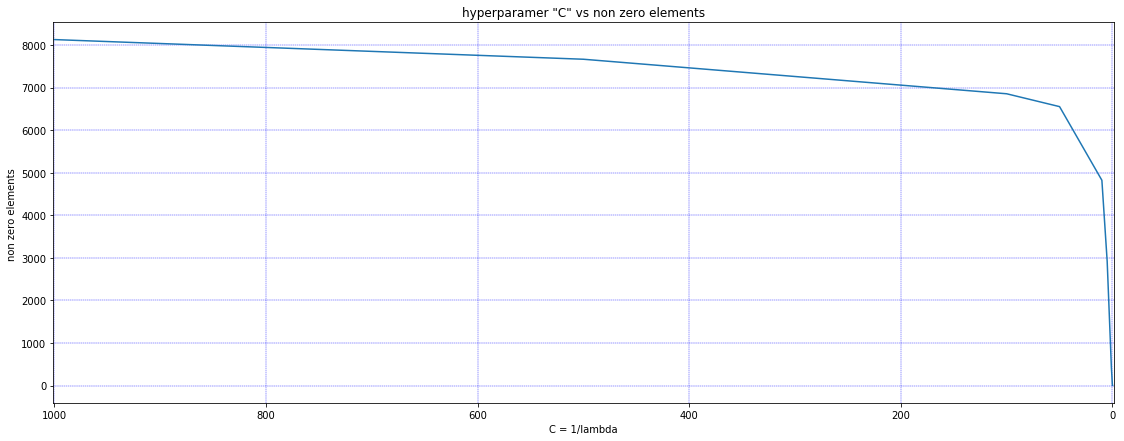

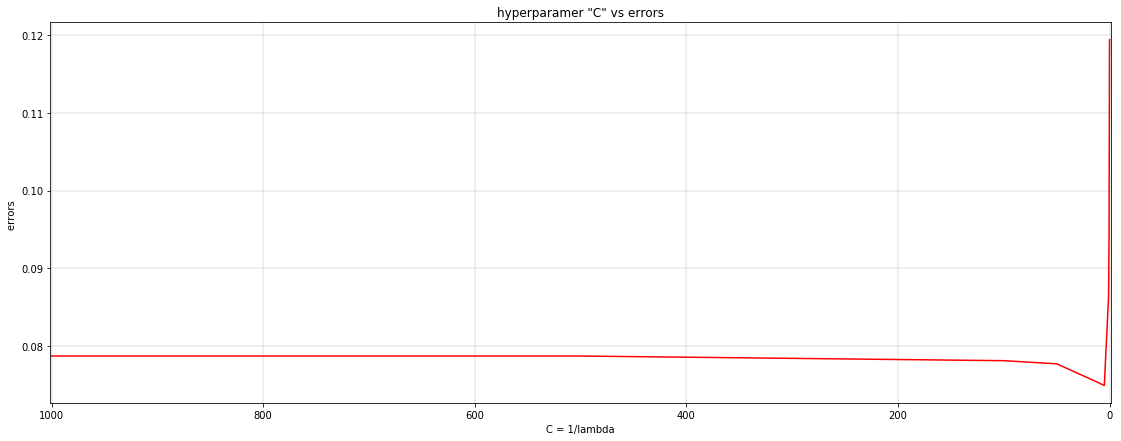

            c  non_zero_element
0   1000.0000              8126
1    500.0000              7664
2    100.0000              6853
3     50.0000              6551
4     10.0000              4821
5      5.0000              2917
6      1.0000               412
7      0.5000               209
8      0.1000                25
9      0.0500                 5
10     0.0100                 0
11     0.0050                 0
12     0.0010                 0
13     0.0005                 0
14     0.0001                 0


             c     error
0   1000.0000  0.078667
1    500.0000  0.078667
2    100.0000  0.078067
3     50.0000  0.077667
4     10.0000  0.075200
5      5.0000  0.074867
6      1.0000  0.086200
7      0.5000  0.094200
8      0.1000  0.118867
9      0.0500  0.119467
10     0.0100  0.119467
11     0.0050  0.119467
12     0.0010  0.119467
13     0.0005  0.119467
14     0.0001  0.119467


In [70]:
# checking the sparsity using "l1" norm hyperparamer and change in 'C'=1/lamda 
C=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
result=sparsity(X,y,C,size=0.70)

#### perturbation test on TF-IDF bigram

In [71]:
n=500000
X=tf_idf_cleaned_text_2gram[:n]
y=filtered_dataset['Score'][:n]

norml=Normalizer()
X=norml.fit_transform(X)


perturbation(X,y,size=0.70)

accuracy before adding noise :  0.9179126382799171
number of non zero elements before adding noise =  2273361

accuracy after adding noise :  0.9179034654827644
number of non zero elements after adding noise =  2273361

number of features which is collinear =  3013


  #### Feature Importance : LR on TF-IDF bigram

In [72]:
clf=model_result_grid.best_estimator_ # model_result from gridsearch_CV

# important --> use the same vectoriser which is used to train LR
feature_importance(tf_idf_2gram,clf,15)

,top positive weights,top positive words,top negative weight,top negative words
0,35.013470,great,-47.397626,worst
1,33.805245,best,-33.571978,time rare
2,33.499936,high recommend,-33.261209,high hope
3,31.804386,delici,-31.585617,store alreadi
4,31.278075,perfect,-29.835072,wors
5,29.012801,love,-29.036214,near good
6,25.214290,amaz,-29.029878,disappoint
7,25.046470,excel,-28.557711,aw
8,24.663926,addict,-27.990860,ice refridger
9,21.986020,hook,-27.878359,unappet


### 3.   Logistic Regression on avg W2V

In [73]:
n=10000
X=sent_vectors[:n]
y=filtered_dataset['Score'][:n]

norml=Normalizer()
X=norml.fit_transform(X)


best estimator : 
 LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
generalization accuracy is = 0.923

 classification report :
               precision    recall  f1-score   support

   negative       0.73      0.44      0.55       320
   positive       0.94      0.98      0.96      2680

avg / total       0.91      0.92      0.91      3000



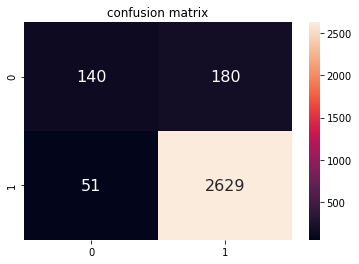

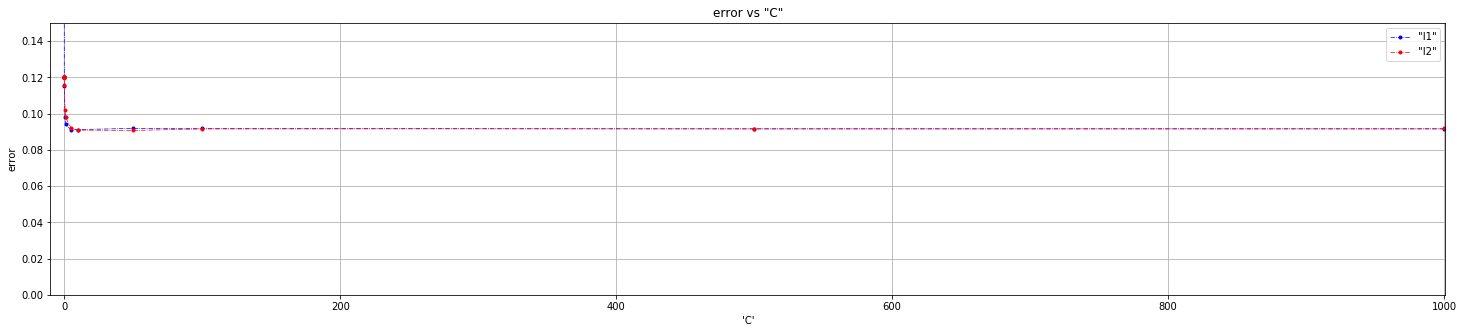

In [74]:
# using GridSearchCV
param={'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} # parameter for gridsearchCV
model_result_grid=logistic_regression_GSCV(X,y,param,size=0.70)
plot_errorvs_C(model_result_grid)


best estimator : 
 LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
generalization accuracy is = 0.9236666666666666

 classification report :
               precision    recall  f1-score   support

   negative       0.74      0.44      0.55       320
   positive       0.94      0.98      0.96      2680

avg / total       0.92      0.92      0.91      3000



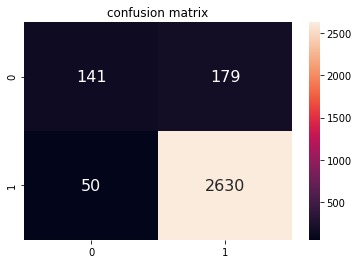

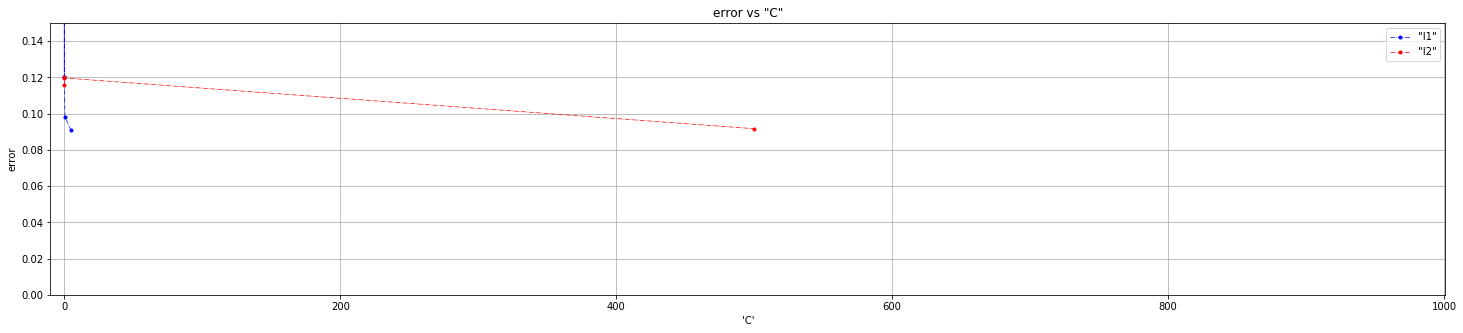

In [75]:
# using RandomSearch Cv
param={'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} # parameter for gridsearchCV
model_result_random=logistic_regression_RSCV(X,y,param,size=0.70)
plot_errorvs_C(model_result_random)

#### Sparsity in avg W2V: change in sparsity with reducing hyperparameter 'C' using 'l1' norm

### 4.  Logistic Regression on avg TF-IDF W2V

In [26]:
n=10000
X=tfidf_sent_vectors[:n]
y=filtered_dataset['Score'][:n]

norml=Normalizer()
X=norml.fit_transform(X)


best estimator : 
 LogisticRegression(C=500, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
generalization accuracy is = 0.9183333333333333

 classification report :
               precision    recall  f1-score   support

   negative       0.73      0.37      0.49       320
   positive       0.93      0.98      0.96      2680

avg / total       0.91      0.92      0.91      3000



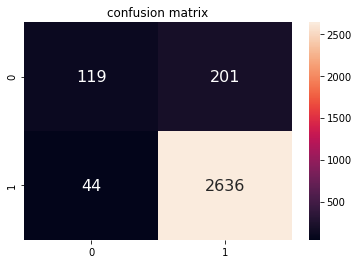

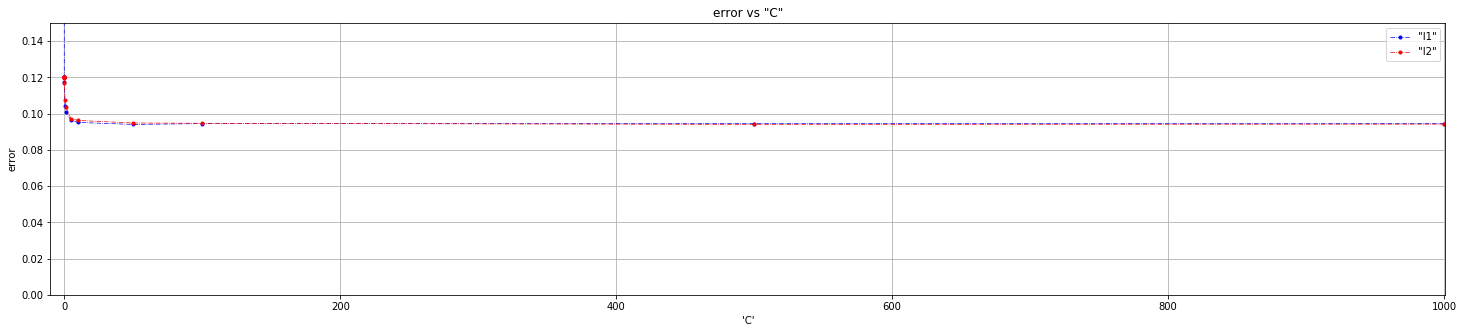

In [27]:
# using GridSearchCV
param={'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} # parameter for gridsearchCV
model_result_grid=logistic_regression_GSCV(X,y,param,size=0.70)
plot_errorvs_C(model_result_grid)


best estimator : 
 LogisticRegression(C=500, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
generalization accuracy is = 0.9183333333333333

 classification report :
               precision    recall  f1-score   support

   negative       0.73      0.37      0.49       320
   positive       0.93      0.98      0.96      2680

avg / total       0.91      0.92      0.91      3000



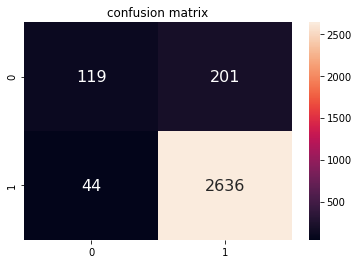

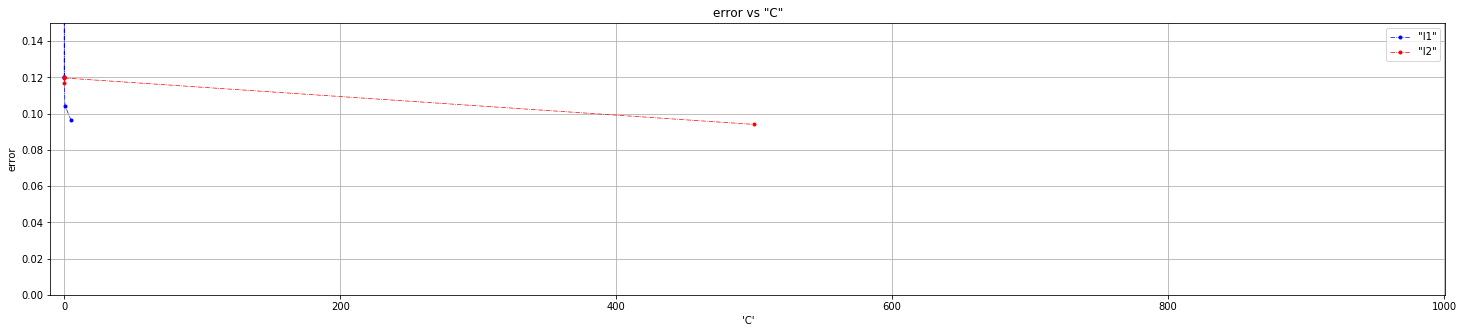

In [28]:
# using RandomSearch Cv
param={'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} # parameter for gridsearchCV
model_result_random=logistic_regression_RSCV(X,y,param,size=0.70)
plot_errorvs_C(model_result_random)

**we are not using Avg W2V and Avg TF-IDF W2V to check Sparsity , Feature Importance  , and Perturbation Test because of the following reason :**

1. All the words are of 50 dimension therefore all the sentence are of 50 dimensions/features that is why results are not interpretable.
2. W2V does not give features names as Text for feature Importance
3. Although we can apply our functions in these vectoriser but interpretation of the result is difficult to understand. 

## Conclusion of Logistic Regresion

1. It is seen that logistic regression works better and faster than above model(Knn and Naive Bayes).
2. Best generalization accuracy on amazon fine food reviews using logistic regression gridsearchCV is 92.93 % on BOW bigram 
3. Logistic regression works faster than Knn and naive bayes as its running time complexity is only O(d)
4. We can also reduce its time complexity further by increasing sparsity(increase lambda=1/c in L1 regulizer) by trading with     errors.
5. Logistic regression is also very useful in feature interpretable as it uses weights to interprate featues.


*NOTE I have trained logistic regression on only 10000 data-points in avg w2v and avg tf-idf w2f becouse of time constrain.